In [3]:
import sys
import numpy as np
import pandas as pd

# Alternate between ../../ and ../../src due to bug
sys.path.append('../..')

from cryptolib.exchange import Binance
from cryptolib.config import config
from cryptolib.enums import Interval

exchange = Binance(config.BINANCE_API_KEY, config.BINANCE_API_SECRET, streaming=True)

# Checking if the values are the same
print(exchange.get_last_price('ETHUSDT'))
print('Sandbox:', exchange.sandbox)
print('Streaming:', exchange.streaming)

1669.46
Sandbox: False
Streaming: True


In [5]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
data = exchange.get_historical_klines("BTCUSDT", Interval.HOUR_4.value)
X = data.index.values.reshape(-1, 1).astype('float32')
y = data.close.values.reshape(-1, 1).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((700, 1), (150, 1), (150, 1), (700, 1), (150, 1), (150, 1))

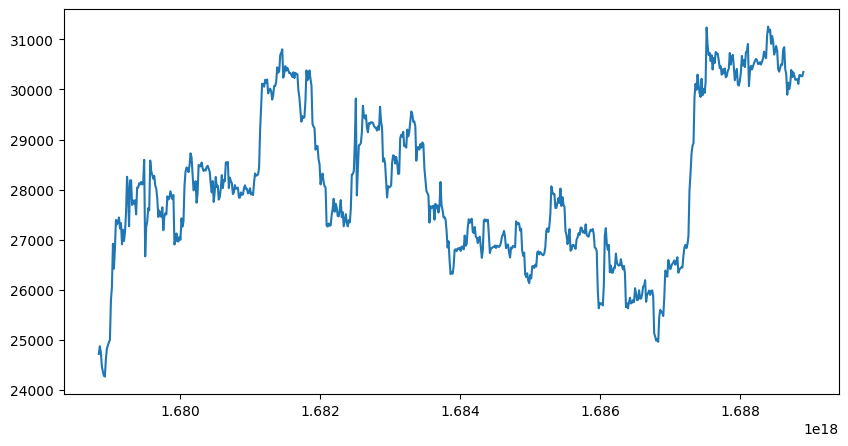

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X_train, y_train, label="close")
plt.show()

In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
lookback = 3
X_train, y_train = create_dataset(X_train, lookback=lookback)
X_test, y_test = create_dataset(X_test, lookback=lookback)
X_val, y_val = create_dataset(X_val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

AttributeError: 'Tensor' object has no attribute '_shape_val'

In [6]:
# fix random seed for reproducibility
tf.random.set_seed(7)

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train[:5], y_train[:5])

(670, 1) (330, 1) (670, 1) (330, 1)
[[0.6706619 ]
 [0.85985565]
 [0.191185  ]
 [0.5405426 ]
 [0.9349289 ]] [[0.88704145]
 [0.79743564]
 [0.69754755]
 [0.59679806]
 [0.8291279 ]]


In [8]:
model = Sequential(
    [
        LSTM(32, input_shape=X_train.shape),
        Dropout(0.2),
        Dense(1)
    ], name="LSTM"
)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [9]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train, y_train,
    epochs=100
)

Epoch 1/100
21/21 [==============================] - 1s 9ms/step - loss: 0.4741
Epoch 2/100
21/21 [==============================] - 0s 6ms/step - loss: 0.3664
Epoch 3/100
21/21 [==============================] - 0s 6ms/step - loss: 0.2695
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 0.1816
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 0.1118
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0644
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0421
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0367
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0340
Epoch 10/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0344
Epoch 11/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0336
Epoch 12/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0342
Epoch 13/100
21/21 [=================

In [11]:
# Valuation
model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 5ms/step - loss: 0.0216


0.021553335711359978

In [18]:
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

# invert predictions
train_prediction = scaler.inverse_transform(train_prediction)
y_train = scaler.inverse_transform([y_train])
test_prediction = scaler.inverse_transform(test_prediction)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train[0], train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[0], test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

11/11 [==============================] - 0s 5ms/step


ValueError: Found array with dim 3. None expected <= 2.